In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

# テキストヘルパースクリプトのロード
import text_helpers

sess = tf.Session()

In [17]:
# 保存先のフォルダが存在しない場合は作成
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [18]:
batch_size = 200            # このモデルのバッチサイズ
embedding_size = 200        # 単語の埋め込みサイズ
vocabulary_size = 2000      # トレーニングの対象となる単語の数
generations = 50000         # トレーニングの実行回数
model_learning_rate = 0.05   # 学習率

num_sampled = int(batch_size/2) # 不正解サンプルの数
window_size = 3                 # 考慮の対象となる前後の単語の数

# トレーニングのチェックポイントを追加
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 1000

In [19]:
# ストップワードを設定
stops = stopwords.words('english')

# 同義語が見つかることを期待して、テストワードを6つ選択
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [20]:
# 映画レビューデータをロード
texts, target = text_helpers.load_movie_data()

# テキストを正規化
texts = text_helpers.normalize_text(texts, stops)

# テキストには少なくとも3つの単語が含まれていなければならない
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]

In [21]:
# データセットとディクショナリを構築
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# テキストワードのキーを取得
valid_examples = [word_dictionary[x] for x in valid_words]

In [22]:
# 単語埋め込みを定義
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
# プレースホルダを作成
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [23]:
# 単語埋め込みを検索し、ウィンドウの埋め込みを結合
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

In [24]:
# NCE損失関数のパラメータ
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# NCE損失関数を設定
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

In [25]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [26]:
saver = tf.train.Saver({"embeddings": embeddings})

In [27]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [28]:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [29]:
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # トレーニングステップを実行
    sess.run(optimizer, feed_dict=feed_dict)

    # 損失値を取得
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # 検証：テストワードと最も関連する上位5つの単語を出力
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # 最も近くにある単語の数
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)
            
    # ディクショナリと埋め込みを保存
    if (i+1) % save_embeddings_every == 0:
        # 語彙ディクショナリを保存
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # 埋め込みを保存
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Loss at step 1000 : 7.155556678771973
Loss at step 2000 : 5.738989353179932
Loss at step 3000 : 5.620214462280273
Loss at step 4000 : 4.568193435668945
Loss at step 5000 : 4.566842555999756
Nearest to love: narc, christian, seeing, score, romance,
Nearest to hate: holes, sympathy, tragic, reminds, safe,
Nearest to happy: entertaining, dancing, utter, giving, place,
Nearest to sad: blue, enjoy, depiction, though, see,
Nearest to man: actors, class, biggest, among, attempt,
Nearest to woman: constructed, given, let, issues, terrific,
Model saved in file: /notebooks/temp/cbow_movie_embeddings.ckpt
Loss at step 6000 : 4.194599628448486
Loss at step 7000 : 4.184915542602539
Loss at step 8000 : 4.411159515380859
Loss at step 9000 : 4.133355617523193
Loss at step 10000 : 4.009302616119385
Nearest to love: narc, score, christian, seeing, romance,
Nearest to hate: holes, sympathy, tragic, reminds, RARE,
Nearest to happy: entertaining, dancing, utter, giving, place,
Nearest to sad: blue, enjoy, 

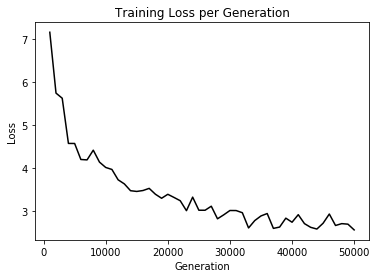

In [30]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()